In [37]:
from google.colab import drive
drive.mount('/content/drive')

Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).


In [38]:
!pip install statannot

Looking in indexes: https://pypi.org/simple, https://us-python.pkg.dev/colab-wheels/public/simple/


In [39]:
import os
import numpy as np
import itertools
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
from statannot import add_stat_annotation
from scipy.stats import shapiro
from scipy.stats import f_oneway
from statsmodels.stats.anova import AnovaRM
from sklearn.metrics import r2_score
from sklearn.metrics import mean_absolute_error
from sklearn.metrics import mean_squared_error
sns.set_style('darkgrid')

In [40]:
import math

def root_mean_squared_error(y_true, y_pred):
  mse = mean_squared_error(y_true, y_pred)
  rmse = math.sqrt(mse)
  return rmse

# Load data

In [41]:
base_dir = os.path.join('drive',
                        'MyDrive',
                        'Github',
                        'water-level-identification',
                        'dataset')

In [42]:
results_dir = os.path.join('drive',
                           'MyDrive',
                           'Github',
                           'water-level-identification',
                           'results')

### Read csv files for each turbidity level

In [43]:
df_t0 = pd.read_csv(os.path.join(base_dir,'testeV1_turbidez0_202209021523.csv'),
                    index_col=0)
df_t1 = pd.read_csv(os.path.join(base_dir,'testeV1_turbidez1_202209021523.csv'),
                    index_col=0)
df_t2 = pd.read_csv(os.path.join(base_dir,'testeV1_turbidez2_202209021523.csv'),
                    index_col=0)
df_t0 = df_t0.apply(pd.to_numeric)
df_t1 = df_t1.apply(pd.to_numeric)
df_t2 = df_t2.apply(pd.to_numeric)

### Concatenate dataframes

In [44]:
df_t0['Turbidity'] = 'low'
df_t1['Turbidity'] = 'medium'
df_t2['Turbidity'] = 'high'
df = pd.concat([df_t0, df_t1, df_t2], ignore_index=True)

### Remove h=350

In [45]:
df = df.drop(df[df['water_level'] == 350].index)

In [46]:
df.head()

,ir_value,ir_strength,us_value,acc_x,acc_y,acc_z,gyr_acc_x,gyr_acc_y,gyr_acc_z,gyr_x,gyr_y,gyr_z,angle,water_level,Turbidity
0,51.0,11255.0,49.5743,1.048,0.144,2.044,-0.000488,0.971191,-0.144531,-0.473282,0.458015,-0.259542,0.0,50.0,low
1,51.0,11245.0,49.5661,1.048,0.160,2.044,0.008545,0.961426,-0.142334,-0.458015,0.480916,-0.274809,0.0,50.0,low
2,51.0,11237.0,49.5702,1.064,0.128,2.044,0.009766,0.963379,-0.151855,-0.442748,0.473282,-0.274809,0.0,50.0,low
3,51.0,11253.0,49.5375,1.056,0.112,2.044,0.006348,0.963623,-0.142334,-0.465649,0.473282,-0.259542,0.0,50.0,low
4,51.0,11253.0,49.5702,1.144,0.112,2.044,0.008057,0.966797,-0.153320,-0.480916,0.488550,-0.259542,0.0,50.0,low


In [47]:
df.describe()

,ir_value,ir_strength,us_value,acc_x,acc_y,acc_z,gyr_acc_x,gyr_acc_y,gyr_acc_z,gyr_x,gyr_y,gyr_z,angle,water_level
count,27000.000000,27000.000000,27000.000000,27000.000000,27000.000000,27000.000000,27000.000000,27000.000000,27000.000000,27000.000000,27000.000000,27000.000000,27000.000000,27000.000000
mean,154.069296,2205.794741,170.899773,1.031625,0.257834,2.038066,-0.090630,0.957849,-0.149197,-0.477236,0.493962,-0.264402,5.000000,175.000000
std,111.185807,3418.548162,84.507107,0.043931,0.085835,0.025337,0.062044,0.012062,0.010590,0.051221,0.025155,0.015680,3.535599,85.392838
min,0.000000,22.000000,27.526700,0.384000,-0.112000,1.488000,-0.463623,0.342041,-0.809082,-2.687020,-1.290080,-0.648855,0.000000,50.000000
25%,52.000000,151.000000,99.304100,1.024000,0.192000,2.044000,-0.138672,0.950928,-0.153809,-0.496183,0.480916,-0.274809,2.500000,100.000000
50%,153.000000,431.000000,150.843000,1.032000,0.256000,2.044000,-0.088623,0.959473,-0.148926,-0.480916,0.496183,-0.267176,5.000000,175.000000
75%,253.000000,3104.250000,248.661000,1.048000,0.320000,2.044000,-0.043945,0.965088,-0.144287,-0.465649,0.503817,-0.259542,7.500000,250.000000
max,386.000000,39587.000000,312.140000,1.752000,0.624000,2.044000,0.549805,1.549070,0.383545,1.076340,1.801530,0.419847,10.000000,300.000000


# Number of zero-valued samples (LiDAR)

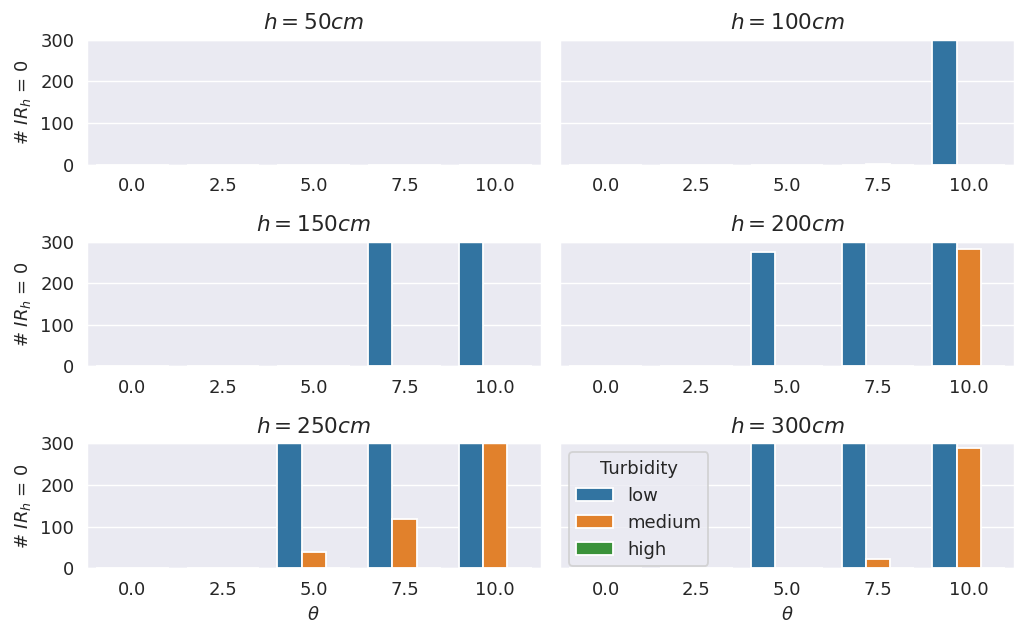

In [48]:
df_zero = df.groupby(['Turbidity', 'angle', 'water_level']
                     ).apply(lambda x: (x['ir_value'] == 0).sum()
                     ).reset_index(name='ir_zero')
df_zero['Turbidity'] = pd.Categorical(df_zero['Turbidity'],
                                      categories=['low', 'medium', 'high'])
df.sort_values(by='Turbidity', inplace=True)

fig, axs = plt.subplots(nrows=3, ncols=2, figsize=(8,5), dpi=130, sharey=True)
for i, level in enumerate([50,100,150,200,250,300]):
  sns.barplot(x='angle',
              y='ir_zero',
              hue='Turbidity',
              data=df_zero[df_zero['water_level'] == level],
              ax=axs[i//2,i%2])
  if i!=5:
    axs[i//2,i%2].legend().set_visible(False)
  axs[i//2,i%2].set_title(f'$h={level}cm$')
  axs[i//2,i%2].set_xlabel('')
  axs[i//2,i%2].set_ylabel('')
  axs[i//2,i%2].set_ylim(0,300)
axs[2,0].set_xlabel('$\\theta$')
axs[2,1].set_xlabel('$\\theta$')
axs[0,0].set_ylabel('# $IR_h$ = 0')
axs[1,0].set_ylabel('# $IR_h$ = 0')
axs[2,0].set_ylabel('# $IR_h$ = 0')
fig.tight_layout()
fig.savefig('/content/drive/MyDrive/Github/water-level-identification/results/ir_nonzero.pdf')

# Angle versus error

A linear correction could be made if the relationship between angle and error was linear. Here, we show it is not.

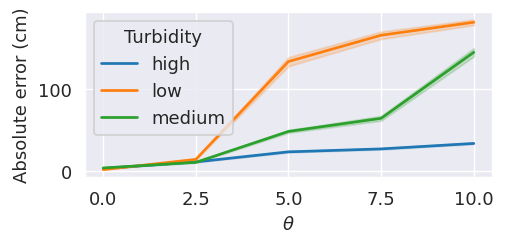

In [49]:
fig, ax = plt.subplots(1, figsize=(4,2), dpi=130)
df_ = df.copy()
df_['err'] = (df_['ir_value'] - df_['water_level']).abs()
sns.lineplot(ax=ax, data=df_, x='angle', y='err', hue='Turbidity')
ax.set_xticks([0, 2.5, 5, 7.5, 10])
ax.set_ylabel('Absolute error (cm)')
ax.set_xlabel('$\\theta$')
fig.tight_layout()
fig.savefig(os.path.join(results_dir,'error_angle.pdf'))

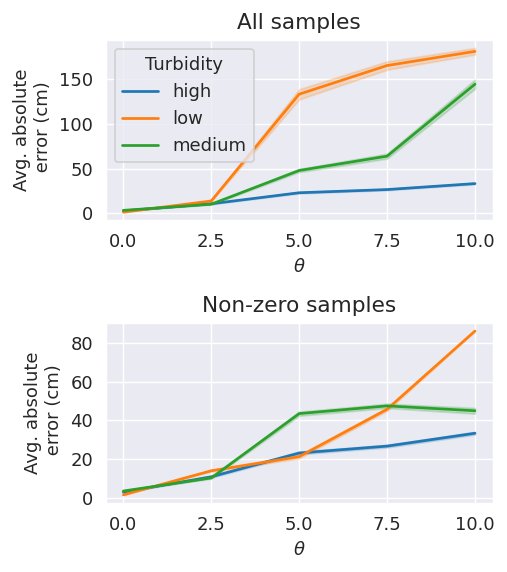

In [50]:
fig, ax = plt.subplots(nrows=2, figsize=(4,4.5), dpi=130)
df_a = df.copy()
df_b = df_a.drop(df_a[df_a['ir_value']==0].index)
for i, df_ in enumerate([df_a, df_b]):
  df_['err'] = (df_['ir_value'] - df_['water_level']).abs()
  sns.lineplot(ax=ax[i], data=df_, x='angle', y='err', hue='Turbidity')
  ax[i].set_xticks([0, 2.5, 5, 7.5, 10])
  ax[i].set_ylabel('Avg. absolute\n error (cm)')
ax[0].set_xlabel('$\\theta$')
ax[1].set_xlabel('$\\theta$')
ax[1].legend().set_visible(False)
ax[0].set_title('All samples')
ax[1].set_title('Non-zero samples')
fig.tight_layout()
fig.savefig(os.path.join(results_dir,'error_angle_alt.pdf'))


### Ultrasonar

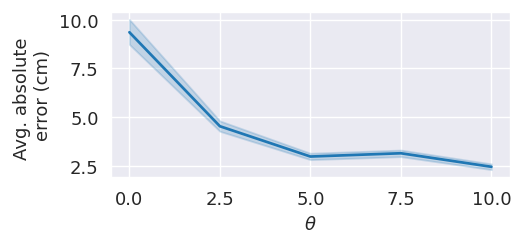

In [51]:
fig, ax = plt.subplots(1, figsize=(4,2), dpi=130)
df_ = df.copy()
df_['err'] = (df_['us_value'] - df_['water_level']).abs()
sns.lineplot(ax=ax, data=df_, x='angle', y='err')
ax.set_xticks([0, 2.5, 5, 7.5, 10])
ax.set_ylabel('Avg. absolute \nerror (cm)')
ax.set_xlabel('$\\theta$')
fig.tight_layout()
fig.savefig(os.path.join(results_dir,'error_angle_us.pdf'))

# Correlation matrix

<ipython-input-52-9f53eb221a3e>:5: FutureWarning: The default value of numeric_only in DataFrame.corr is deprecated. In a future version, it will default to False. Select only valid columns or specify the value of numeric_only to silence this warning.
  correlation_matrix = df_.corr()


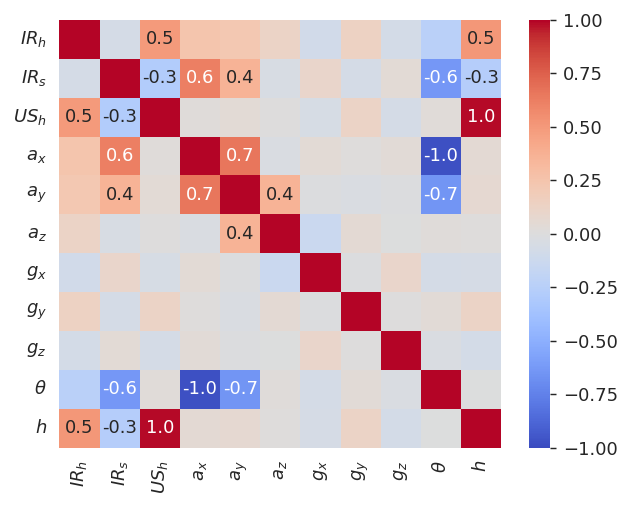

In [52]:
thres = 0.25

df_ = df.copy()
df_ = df_.drop(['acc_x','acc_y','acc_z'], axis=1)
correlation_matrix = df_.corr()
labels = np.where(np.abs(correlation_matrix) > thres,
                  correlation_matrix.round(1).astype(str), '')
np.fill_diagonal(labels, "")
fig, ax = plt.subplots(1, figsize=(5,4), dpi=130)
heatmap = sns.heatmap(ax=ax,
                      data=correlation_matrix,
                      annot=labels, fmt='',
                      cmap='coolwarm',
                      vmin=-1, vmax=1)
ticklabels = ['$IR_h$',
              '$IR_s$',
              '$US_h$',
              '$a_x$',
              '$a_y$',
              '$a_z$',
              '$g_x$',
              '$g_y$',
              '$g_z$',
              '$\\theta$',
              '$h$']
ax.set_xticklabels(ticklabels)
ax.set_yticklabels(ticklabels)
fig.tight_layout()
fig.savefig(os.path.join(results_dir,'corr.pdf'))

# Baseline error analysis

First, we provide a lower reference for performance, corresponding to the sensors' measurement without any adjustment.

## Ultrasound sensor

In [53]:
for i, df_ in enumerate([df_t0, df_t1, df_t2]):
  df_ = df_.groupby(['water_level','angle','Turbidity']).median()
  df_ = df_.reset_index()
  mae = mean_absolute_error(df_['water_level'], df_['us_value'])
  rmse = root_mean_squared_error(df_['water_level'], df_['us_value'])
  r2 = r2_score(df_['water_level'], df_['us_value'])
  print(f'Turbidity={i}')
  print(f'MAE: {mae:.2f} \nRMSE: {rmse:.2f} \nR2: {r2:.2f}\n')

Turbidity=0
MAE: 10.15 
RMSE: 44.61 
R2: 0.80

Turbidity=1
MAE: 12.57 
RMSE: 45.50 
R2: 0.79

Turbidity=2
MAE: 8.58 
RMSE: 44.78 
R2: 0.80



## Infrared sensor

In [54]:
for i, df_ in enumerate([df_t0, df_t1, df_t2]):
  df_ = df_.groupby(['water_level','angle','Turbidity']).median()
  df_ = df_.reset_index()
  mae = mean_absolute_error(df_['water_level'], df_['ir_value'])
  rmse = root_mean_squared_error(df_['water_level'], df_['ir_value'])
  r2 = r2_score(df_['water_level'], df_['ir_value'])
  print(f'Turbidity={i}')
  print(f'MAE: {mae:.2f} \nRMSE: {rmse:.2f} \nR2: {r2:.2f}\n')

Turbidity=0
MAE: 115.83 
RMSE: 170.35 
R2: -1.90

Turbidity=1
MAE: 48.41 
RMSE: 82.99 
R2: 0.31

Turbidity=2
MAE: 21.13 
RMSE: 27.23 
R2: 0.93



## Boxplots and significance tests

### Compute error in dataframe

In [55]:
def grouped_df_raw_nomelt(df):
  categories = ['low','medium','high']
  df_grouped = df.groupby(['water_level','angle','Turbidity']).median()
  df_grouped = df_grouped.reset_index()
  df_grouped['abs_error_us'] = (df_grouped['water_level'] -
                                df_grouped['us_value']).abs()
  df_grouped['abs_error_ir'] = (df_grouped['water_level'] -
                                df_grouped['ir_value']).abs()
  df_grouped['Turbidity'] = pd.Categorical(df_grouped['Turbidity'],
                                          categories=categories)
  df_grouped = df_grouped.sort_values('Turbidity')
  return df_grouped

### Generate boxplots with statistical signiicance

First, perform One-Way ANOVA test.

In [56]:
df_grouped = grouped_df_raw_nomelt(df)
fvalue, pvalue = f_oneway(df_grouped[df_grouped['Turbidity']=='low']['abs_error_ir'],
                          df_grouped[df_grouped['Turbidity']=='medium']['abs_error_ir'],
                          df_grouped[df_grouped['Turbidity']=='high']['abs_error_ir'])
print('Infrared', fvalue, pvalue)
fvalue, pvalue = f_oneway(df_grouped[df_grouped['Turbidity']=='low']['abs_error_us'],
                          df_grouped[df_grouped['Turbidity']=='medium']['abs_error_us'],
                          df_grouped[df_grouped['Turbidity']=='high']['abs_error_us'])
print('Ultrasound', fvalue, pvalue)

Infrared 8.218341610181083 0.0005379513400447416
Ultrasound 3.9758480044856004 0.022269931917608624


Now, we can perform post-hoc t-tests.

p-value annotation legend:
ns: 5.00e-02 < p <= 1.00e+00
*: 1.00e-02 < p <= 5.00e-02
**: 1.00e-03 < p <= 1.00e-02
***: 1.00e-04 < p <= 1.00e-03
****: p <= 1.00e-04

low v.s. medium: t-test independent samples with Bonferroni correction, P_val=1.432e-01 stat=2.023e+00
medium v.s. high: t-test independent samples with Bonferroni correction, P_val=8.215e-02 stat=2.263e+00
low v.s. high: t-test independent samples with Bonferroni correction, P_val=6.830e-04 stat=3.932e+00


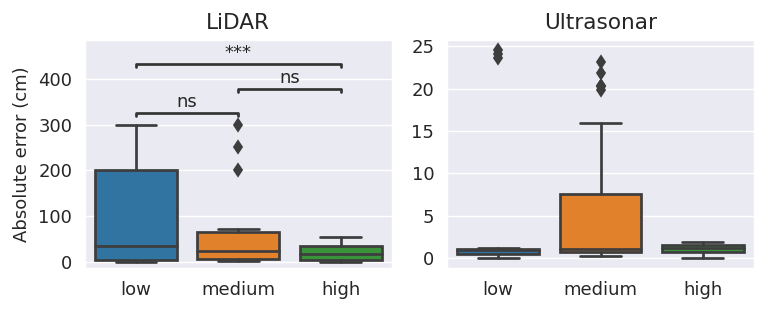

In [57]:
fig,ax = plt.subplots(ncols=2, figsize=(6,2.5), dpi=130)
#fig,ax = plt.subplots(nrows=2, figsize=(2.5,4), dpi=130)
df_grouped = grouped_df_raw_nomelt(df)
for i, y_var in enumerate(['abs_error_ir','abs_error_us']):
  sns.boxplot(ax=ax[i], data=df_grouped, x='Turbidity', y=y_var)
  box_pairs=[('low', 'medium'),
              ('medium', 'high'),
              ('low','high')]
  if y_var == 'abs_error_ir':
    test_results = add_stat_annotation(ax[i],
                                      data=df_grouped,
                                      x='Turbidity',
                                      y=y_var,
                                      box_pairs=box_pairs,
                                      test='t-test_ind',
                                      text_format='star',
                                      loc='inside',
                                      verbose=2)
ax[0].set_title('LiDAR')
ax[1].set_title('Ultrasonar')
ax[0].set_ylabel('Absolute error (cm)')
#ax[1].set_ylabel('Absolute error (cm)')
ax[1].set_ylabel('')
ax[0].set_xlabel('')
ax[1].set_xlabel('')
fig.tight_layout()
fig.savefig(os.path.join(results_dir,'sensors_error.pdf'))

### Is infrared with high turbidity better than ultrasound?

In [58]:
def grouped_df_raw(df):
  df_grouped = df.groupby(['water_level','angle','Turbidity']).median()
  df_grouped = df_grouped.reset_index()
  df_grouped = pd.melt(df_grouped,
                      id_vars=['water_level','angle','Turbidity'],
                      value_vars=['ir_value','us_value'],
                      var_name='modality',
                      value_name='sensor value')
  df_grouped['abs_error'] = (df_grouped['water_level'] -
                             df_grouped['sensor value']).abs()
  return df_grouped

p-value annotation legend:
ns: 5.00e-02 < p <= 1.00e+00
*: 1.00e-02 < p <= 5.00e-02
**: 1.00e-03 < p <= 1.00e-02
***: 1.00e-04 < p <= 1.00e-03
****: p <= 1.00e-04

ir_value v.s. us_value: t-test independent samples with Bonferroni correction, P_val=3.411e-03 stat=-3.054e+00
p-value annotation legend:
ns: 5.00e-02 < p <= 1.00e+00
*: 1.00e-02 < p <= 5.00e-02
**: 1.00e-03 < p <= 1.00e-02
***: 1.00e-04 < p <= 1.00e-03
****: p <= 1.00e-04

ir_value v.s. us_value: t-test independent samples with Bonferroni correction, P_val=8.428e-01 stat=1.992e-01
p-value annotation legend:
ns: 5.00e-02 < p <= 1.00e+00
*: 1.00e-02 < p <= 5.00e-02
**: 1.00e-03 < p <= 1.00e-02
***: 1.00e-04 < p <= 1.00e-03
****: p <= 1.00e-04

ir_value v.s. us_value: t-test independent samples with Bonferroni correction, P_val=3.988e-01 stat=8.501e-01


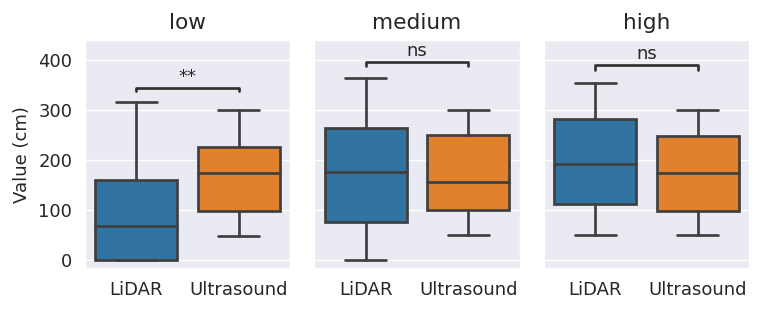

In [59]:
fig,ax = plt.subplots(ncols=3, figsize=(6,2.5), sharey=True, dpi=130)
#fig,ax = plt.subplots(nrows=3, figsize=(2.5,6), sharey=True, dpi=130)
df_grouped = grouped_df_raw(df)
for i, turbidity in enumerate(['low','medium','high']):
  df_ = df_grouped[df_grouped['Turbidity']==turbidity]
  sns.boxplot(ax=ax[i], data=df_, x='modality', y='sensor value')
  box_pairs=[('ir_value', 'us_value')]
  test_results = add_stat_annotation(ax[i],
                                     data=df_,
                                     x='modality',
                                     y='sensor value',
                                     box_pairs=box_pairs,
                                     test='t-test_ind',
                                     text_format='star',
                                     loc='inside',
                                     verbose=2)
  ax[i].set_title(turbidity)
  ax[i].set_xticklabels(['LiDAR','Ultrasound'])
ax[0].set_ylabel('Value (cm)')
ax[1].set_ylabel('')
ax[2].set_ylabel('')
#ax[1].set_ylabel('Value (cm)')
#ax[2].set_ylabel('Value (cm)')
ax[0].set_xlabel('')
ax[1].set_xlabel('')
ax[2].set_xlabel('')
fig.tight_layout()
fig.savefig(os.path.join(results_dir,'sensor_values.pdf'))

# Machine learning models to approximate the water level

## Split data

Data collection involved generating individual data streams for each controlled factor, namely angle, turbidity, and water level. These streams were comprised of sequential data points that were recorded at a high sampling rate. While the sensors' readings within a stream were subject to some noise and minor environmental factors, there was relatively little variance within each stream, barring sensor failures. Therefore, including leaked data points from the same stream, even those that were distinct, in the training and test sets would not be an optimal validation strategy. This is because the test data would be too similar to the training data, and therefore, would not accurately reflect the actual production data.

We defined a train/test split for each permutation of (angle,water_level,turbidity). If we consider that one prediction can be obtained from each stream, defined by this tuple, this approach may be called leave-one-out. We end up with 105 splits.



In [60]:
angle = df['angle'].unique()
level = df['water_level'].unique()
turb = df['Turbidity'].unique()

permuts = list(itertools.product(angle, level, turb))
print([f'{x}\n' for x in permuts])
print(len(permuts))

["(10.0, 300.0, 'high')\n", "(10.0, 300.0, 'low')\n", "(10.0, 300.0, 'medium')\n", "(10.0, 100.0, 'high')\n", "(10.0, 100.0, 'low')\n", "(10.0, 100.0, 'medium')\n", "(10.0, 150.0, 'high')\n", "(10.0, 150.0, 'low')\n", "(10.0, 150.0, 'medium')\n", "(10.0, 50.0, 'high')\n", "(10.0, 50.0, 'low')\n", "(10.0, 50.0, 'medium')\n", "(10.0, 200.0, 'high')\n", "(10.0, 200.0, 'low')\n", "(10.0, 200.0, 'medium')\n", "(10.0, 250.0, 'high')\n", "(10.0, 250.0, 'low')\n", "(10.0, 250.0, 'medium')\n", "(0.0, 300.0, 'high')\n", "(0.0, 300.0, 'low')\n", "(0.0, 300.0, 'medium')\n", "(0.0, 100.0, 'high')\n", "(0.0, 100.0, 'low')\n", "(0.0, 100.0, 'medium')\n", "(0.0, 150.0, 'high')\n", "(0.0, 150.0, 'low')\n", "(0.0, 150.0, 'medium')\n", "(0.0, 50.0, 'high')\n", "(0.0, 50.0, 'low')\n", "(0.0, 50.0, 'medium')\n", "(0.0, 200.0, 'high')\n", "(0.0, 200.0, 'low')\n", "(0.0, 200.0, 'medium')\n", "(0.0, 250.0, 'high')\n", "(0.0, 250.0, 'low')\n", "(0.0, 250.0, 'medium')\n", "(2.5, 300.0, 'high')\n", "(2.5, 300.0,

Besides removing the target *water_level* from the input data, we also need to remove the other controlled factors, it is, angle and turbidity. All input variables must be sensor data that can be obtained without human inspection. Next, we built a function to get the training and test data of a split based on its index.

In [61]:
def get_split(idx, modality):
  if modality == 'us_value':
    drop_list = ['water_level','angle','Turbidity','ir_value','ir_strength',
                 'acc_x', 'acc_y', 'acc_z']
  else:
    drop_list = ['water_level','angle','Turbidity','us_value',
                 'acc_x', 'acc_y', 'acc_z']

  vals = permuts[idx]
  df_test = df[(df['angle'] == vals[0]) &
               (df['water_level'] == vals[1]) &
               (df['Turbidity'] == vals[2])]
  df_train = pd.concat([df,df_test]).drop_duplicates(keep=False)
  X_train = df_train.drop(drop_list,
                          axis=1)
  X_test = df_test.drop(drop_list,
                        axis=1)
  y_train = df_train['water_level']
  y_test = df_test['water_level']
  return X_train, X_test, y_train, y_test

### Verifying and gathering information

In [62]:
X_train, X_test, y_train, y_test = get_split(8, 'us_value')
us_features = X_train.columns
X_train

,us_value,gyr_acc_x,gyr_acc_y,gyr_acc_z,gyr_x,gyr_y,gyr_z
29999,298.3580,-0.177002,0.944580,-0.147461,-0.488550,0.511450,-0.267176
23990,100.1720,-0.182129,0.938965,-0.151367,-0.496183,0.488550,-0.259542
23991,99.3982,-0.173584,0.949463,-0.157959,-0.465649,0.480916,-0.267176
23992,98.9768,-0.184082,0.945801,-0.142822,-0.465649,0.496183,-0.267176
23993,100.2210,-0.177490,0.942139,-0.139648,-0.496183,0.503817,-0.259542
...,...,...,...,...,...,...,...
16500,250.1140,-0.011230,0.967041,-0.154297,-0.496183,0.488550,-0.236641
16499,201.7390,-0.173828,0.942139,-0.155518,-0.503817,0.503817,-0.259542
16498,200.4580,-0.174561,0.952148,-0.161621,-0.473282,0.503817,-0.259542
16497,200.4090,-0.172363,0.950439,-0.147217,-0.488550,0.488550,-0.251908


In [63]:
X_train, X_test, y_train, y_test = get_split(8, 'ir_value')
ir_features = X_train.columns
X_train

,ir_value,ir_strength,gyr_acc_x,gyr_acc_y,gyr_acc_z,gyr_x,gyr_y,gyr_z
29999,353.0,189.0,-0.177002,0.944580,-0.147461,-0.488550,0.511450,-0.267176
23990,118.0,960.0,-0.182129,0.938965,-0.151367,-0.496183,0.488550,-0.259542
23991,118.0,966.0,-0.173584,0.949463,-0.157959,-0.465649,0.480916,-0.267176
23992,118.0,975.0,-0.184082,0.945801,-0.142822,-0.465649,0.496183,-0.267176
23993,118.0,975.0,-0.177490,0.942139,-0.139648,-0.496183,0.503817,-0.259542
...,...,...,...,...,...,...,...,...
16500,253.0,6135.0,-0.011230,0.967041,-0.154297,-0.496183,0.488550,-0.236641
16499,0.0,92.0,-0.173828,0.942139,-0.155518,-0.503817,0.503817,-0.259542
16498,0.0,91.0,-0.174561,0.952148,-0.161621,-0.473282,0.503817,-0.259542
16497,0.0,86.0,-0.172363,0.950439,-0.147217,-0.488550,0.488550,-0.251908


In [64]:
X_test

,ir_value,ir_strength,gyr_acc_x,gyr_acc_y,gyr_acc_z,gyr_x,gyr_y,gyr_z
14700,221.0,150.0,-0.172607,0.945557,-0.157959,-0.480916,0.496183,-0.251908
14701,221.0,147.0,-0.179932,0.942139,-0.141846,-0.480916,0.511450,-0.274809
14702,221.0,145.0,-0.183594,0.953369,-0.145752,-0.427481,0.473282,-0.274809
14716,222.0,140.0,-0.179443,0.949707,-0.134521,-0.526718,0.496183,-0.290076
14715,219.0,148.0,-0.178711,0.944824,-0.145752,-0.473282,0.503817,-0.274809
...,...,...,...,...,...,...,...,...
14810,222.0,149.0,-0.178467,0.950684,-0.148682,-0.480916,0.503817,-0.267176
14809,222.0,147.0,-0.178467,0.940430,-0.144531,-0.480916,0.511450,-0.244275
14815,222.0,147.0,-0.182129,0.952148,-0.147949,-0.496183,0.480916,-0.282443
14998,222.0,154.0,-0.178955,0.942383,-0.153564,-0.488550,0.496183,-0.251908


In [65]:
y_train

29999    300.0
23990    100.0
23991    100.0
23992    100.0
23993    100.0
         ...  
16500    250.0
16499    200.0
16498    200.0
16497    200.0
16503    250.0
Name: water_level, Length: 26700, dtype: float64

In [66]:
y_test

14700    150.0
14701    150.0
14702    150.0
14716    150.0
14715    150.0
         ...  
14810    150.0
14809    150.0
14815    150.0
14998    150.0
14999    150.0
Name: water_level, Length: 300, dtype: float64

## Preprocessing

In [67]:
def get_split_numpy(idx, modality):
  X_train, X_test, y_train, y_test = get_split(idx,modality)
  X_train = X_train.to_numpy()
  X_test = X_test.to_numpy()
  y_train = y_train.to_numpy()
  y_test = y_test.to_numpy()
  return X_train, X_test, y_train, y_test

### Normalize

Apply z-score normalization to the variables and targets.

In [68]:
from sklearn.preprocessing import StandardScaler

def get_normalized_split(idx, modality):
  X_train, X_test, y_train, y_test = get_split_numpy(idx, modality)
  scaler = StandardScaler()
  scaler = scaler.fit(X_train)
  X_train = scaler.transform(X_train)
  X_test = scaler.transform(X_test)
  return X_train, X_test, y_train, y_test

## ML pipeline

In [69]:
from sklearn.ensemble import RandomForestRegressor
from sklearn.ensemble import AdaBoostRegressor
from sklearn.linear_model import LinearRegression
from sklearn.neighbors import KNeighborsRegressor
from sklearn.tree import DecisionTreeRegressor

def retrieve_regressor(ml_arch, seed=1):
  if ml_arch == 'random_forest':
    regr = RandomForestRegressor(random_state=seed)
  elif ml_arch == 'adaboost':
    regr = AdaBoostRegressor(estimator=DecisionTreeRegressor(max_depth=10),
                             n_estimators=150,
                             learning_rate=0.5,
                             random_state=seed)
  elif ml_arch == 'linear_regression':
    regr = LinearRegression()
  elif ml_arch == 'knn':
    regr = KNeighborsRegressor()
  return regr

In [70]:
def train_regressor(modality='ir_value',
                    res_fname='rf.csv',
                    ml_arch='random_forest',
                    feature_names=None):
  columns = ['angle', 'level', 'turbidity', 'y_true', 'y_pred']
  df_res = pd.DataFrame(columns=columns)
  df_imps = pd.DataFrame(columns=feature_names)
  for i, permut in enumerate(permuts):
    print(i, permut)
    X_train, X_test, y_train, y_test = get_normalized_split(i, modality)
    regr = retrieve_regressor(ml_arch)
    regr = regr.fit(X_train,y_train)
    y_pred = regr.predict(X_test)
    df_aux = pd.DataFrame({'angle': permut[0],
                          'level': permut[1],
                          'turbidity': permut[2],
                          'y_true': y_test,
                          'y_pred': y_pred})
    df_res = pd.concat([df_res,df_aux], ignore_index=True)
    if feature_names is not None:
      df_imps_aux = pd.DataFrame(data = [regr.feature_importances_],
                                 columns = feature_names)
      df_imps = pd.concat([df_imps, df_imps_aux], ignore_index=True)
  df_res.to_csv(os.path.join(results_dir,res_fname))
  df_imps.to_csv(os.path.join(results_dir,'importances_'+res_fname))
  return df_res, df_imps

### Loading predictions from models trained previously

In [71]:
def load_results(fname):
  df_res = pd.read_csv(os.path.join(results_dir,fname),
                      index_col=0)
  df_res['angle']  = pd.to_numeric(df_res['angle'])
  df_res['level']  = pd.to_numeric(df_res['level'])
  df_res['y_true'] = pd.to_numeric(df_res['y_true'])
  df_res['y_pred'] = pd.to_numeric(df_res['y_pred'])
  return df_res

## Results evaluation

Generate dataframe with metrics for results evaluation.

In [72]:
def eval_model(df_res, model_name):
  mae = mean_absolute_error(df_res['y_true'], df_res['y_pred'])
  rmse = root_mean_squared_error(df_res['y_true'], df_res['y_pred'])
  r2 = r2_score(df_res['y_true'], df_res['y_pred'])
  df_res_metrics = pd.DataFrame({'Model': [model_name],
                                 'Turbidity': ['Overall'],
                                 'MAE': [mae],
                                 'RMSE': [rmse],
                                 'R2': [r2]})
  for i, turbidity in enumerate(['low', 'medium', 'high']):
    df_ = df_res[df_res['turbidity'] == turbidity]
    df_ = df_.groupby(['y_true','angle','turbidity']).median(numeric_only=True)
    df_ = df_.reset_index()
    mae = mean_absolute_error(df_['y_true'], df_['y_pred'])
    rmse = root_mean_squared_error(df_['y_true'], df_['y_pred'])
    r2 = r2_score(df_['y_true'], df_['y_pred'])
    df_row = pd.DataFrame({'Model': [model_name],
                           'Turbidity': [turbidity],
                           'MAE': [mae],
                           'RMSE': [rmse],
                           'R2': [r2]})
    df_res_metrics = pd.concat([df_res_metrics, df_row],
                               ignore_index=True)
  return df_res_metrics

In [73]:
def eval_model_angle(df_res, model_name):
  columns = ['Model','Angle','MAE','RMSE','R2']
  df_res_metrics = pd.DataFrame(columns=columns)
  for i, angle in enumerate([0,2.5,5,7.5,10]):
    df_ = df_res[df_res['angle'] == angle]
    df_ = df_.groupby(['y_true','angle','turbidity']).median(numeric_only=True)
    df_ = df_.reset_index()
    mae = mean_absolute_error(df_['y_true'], df_['y_pred'])
    rmse = root_mean_squared_error(df_['y_true'], df_['y_pred'])
    r2 = r2_score(df_['y_true'], df_['y_pred'])
    df_row = pd.DataFrame({'Model': [model_name],
                           'Angle': [angle],
                           'MAE': [mae],
                           'RMSE': [rmse],
                           'R2': [r2]})
    df_res_metrics = pd.concat([df_res_metrics, df_row],
                               ignore_index=True)
  return df_res_metrics

## Infrared

In [74]:
#df_res = train_regressor('ir_value', 'lr_ir.csv', 'linear_regression')

In [75]:
#df_res = train_regressor('ir_value', 'knn_ir.csv', 'knn')

In [76]:
#df_res, df_imps = train_regressor('ir_value', 'rf_ir.csv', 'random_forest', ir_features)

In [77]:
#df_res = train_regressor('ir_value', 'ada_ir.csv', 'adaboost', ir_features)

In [78]:
#df_res = load_results('lr_ir.csv')
#df_res

In [79]:
df_res = load_results('lr_ir.csv')
df_res_lr = eval_model(df_res, model_name='Linear Regression')

df_res = load_results('knn_ir.csv')
df_res_knn = eval_model(df_res, model_name='KNN')

df_res = load_results('rf_ir.csv')
df_res_rf = eval_model(df_res, model_name='Random Forest')

df_res = load_results('ada_ir.csv')
df_res_ada = eval_model(df_res, model_name='AdaBoost')

df_res_metrics = pd.concat([df_res_lr,
                            df_res_knn,
                            df_res_rf,
                            df_res_ada],
                           ignore_index=True)
df_res_metrics.sort_values(by='Turbidity').round(2)

,Model,Turbidity,MAE,RMSE,R2
0,Linear Regression,Overall,59.68,72.90,0.27
4,KNN,Overall,27.99,42.31,0.75
8,Random Forest,Overall,15.04,34.92,0.83
12,AdaBoost,Overall,15.70,35.81,0.82
3,Linear Regression,high,42.76,50.29,0.65
7,KNN,high,16.17,22.97,0.93
11,Random Forest,high,1.90,9.06,0.99
15,AdaBoost,high,1.67,9.13,0.99
1,Linear Regression,low,74.86,88.87,-0.08
5,KNN,low,34.67,49.80,0.66


## Ultrasound

In [80]:
#df_res = train_regressor('us_value', 'lr_us.csv', 'linear_regression')

In [81]:
#df_res = train_regressor('us_value', 'knn_us.csv', 'knn')

In [82]:
#df_res = train_regressor('us_value', 'rf_us.csv', 'random_forest', us_features)

In [83]:
#df_res = train_regressor('us_value', 'ada_us.csv', 'adaboost', us_features)

In [84]:
df_res = load_results('lr_us.csv')
df_res_lr = eval_model(df_res, model_name='Linear Regression')

df_res = load_results('knn_us.csv')
df_res_knn = eval_model(df_res, model_name='KNN')

df_res = load_results('rf_us.csv')
df_res_rf = eval_model(df_res, model_name='Random Forest')

df_res = load_results('ada_us.csv')
df_res_ada = eval_model(df_res, model_name='AdaBoost')

df_res_metrics = pd.concat([df_res_lr,
                            df_res_knn,
                            df_res_rf,
                            df_res_ada],
                           ignore_index=True)
df_res_metrics.sort_values(by='Turbidity').round(2)

,Model,Turbidity,MAE,RMSE,R2
0,Linear Regression,Overall,6.21,13.00,0.98
4,KNN,Overall,10.36,19.64,0.95
8,Random Forest,Overall,0.92,8.00,0.99
12,AdaBoost,Overall,1.17,12.85,0.98
3,Linear Regression,high,3.64,4.35,1.00
7,KNN,high,3.67,9.83,0.99
11,Random Forest,high,0.07,0.37,1.00
15,AdaBoost,high,0.00,0.00,1.00
1,Linear Regression,low,4.77,7.34,0.99
5,KNN,low,5.33,8.94,0.99


# Results analysis

In [85]:
df_res_ir_lr  = load_results('lr_ir.csv')
df_res_ir_knn = load_results('knn_ir.csv')
df_res_ir_rf  = load_results('rf_ir.csv')
df_res_ir_ada = load_results('ada_ir.csv')
df_res_ir_lr['Model']  = 'LR'
df_res_ir_knn['Model'] = 'KNN'
df_res_ir_rf['Model']  = 'RF'
df_res_ir_ada['Model'] = 'Ada'
df_res_ir = pd.concat([df_res_ir_lr,
                       df_res_ir_knn,
                       df_res_ir_rf,
                       df_res_ir_ada])
df_res_ir['Sensor'] = 'Infrared'

df_res_us_lr  = load_results('lr_us.csv')
df_res_us_knn = load_results('knn_us.csv')
df_res_us_rf  = load_results('rf_us.csv')
df_res_us_ada = load_results('ada_us.csv')
df_res_us_lr['Model']  = 'LR'
df_res_us_knn['Model'] = 'KNN'
df_res_us_rf['Model']  = 'RF'
df_res_us_ada['Model'] = 'Ada'
df_res_us = pd.concat([df_res_us_lr,
                       df_res_us_knn,
                       df_res_us_rf,
                       df_res_us_ada])
df_res_us['Sensor'] = 'Ultrasound'

df_res_all = pd.concat([df_res_ir,df_res_us])
df_res_all.head()

,angle,level,turbidity,y_true,y_pred,Model,Sensor
0,0.0,50.0,low,50.0,78.778482,LR,Infrared
1,0.0,50.0,low,50.0,83.703627,LR,Infrared
2,0.0,50.0,low,50.0,88.213052,LR,Infrared
3,0.0,50.0,low,50.0,79.833364,LR,Infrared
4,0.0,50.0,low,50.0,88.574359,LR,Infrared


### Comparing models

In [86]:
def grouped_df_ml(df_res_all):
  df_grouped_ml = df_res_all.groupby(['level',
                                  'angle',
                                  'turbidity',
                                  'Model',
                                  'Sensor']).median()
  df_grouped_ml = df_grouped_ml.reset_index()
  df_grouped_ml['Error'] = (df_grouped_ml['y_true'] -
                        df_grouped_ml['y_pred']).abs()
  return df_grouped_ml

In [87]:
def compare_models(sensor, df_grouped):
  if sensor=='Infrared':
    fig, ax = plt.subplots(ncols=4, sharey=True, figsize=(9,2.5), dpi=130)
    turbs = [None, 'low', 'medium', 'high']
  else:
    fig, ax = plt.subplots(1, figsize=(3,2.5), dpi=130)
    turbs = [None]
    ax = [ax]
  df_a = df_grouped[df_grouped['Sensor']==sensor]
  for i, turbidity in enumerate(turbs):
    if sensor=='Infrared':
      ax[i].set_ylim(0,500)
    else:
      ax[i].set_ylim(0,400)
    if turbidity is None:
      df_b = df_a
      ax[i].set_title('Overall')
    else:
      df_b = df_a[df_a['turbidity']==turbidity]
      ax[i].set_title(turbidity)
    sns.boxplot(ax=ax[i], data=df_b, x='Model', y='Error')
    box_pairs=[('RF', 'Ada'),
              ('KNN', 'LR'),
              ('Ada', 'KNN'),
              ('Ada', 'LR'),
              ('RF', 'LR'),
              ('RF','KNN')]
    test_results = add_stat_annotation(ax[i],
                                      data=df_b,
                                      x='Model',
                                      y='Error',
                                      box_pairs=box_pairs,
                                      test='t-test_paired',
                                      text_format='star',
                                      loc='inside',
                                      verbose=2)
    if sensor=='Infrared':
      ax[i].set_ylim(0,600)
      ax[1].set_ylabel('')
      ax[2].set_ylabel('')
      ax[3].set_ylabel('')
      ax[1].set_xlabel('')
      ax[2].set_xlabel('')
      ax[3].set_xlabel('')
  ax[0].set_ylabel('Absolute error (cm)')
  ax[0].set_xlabel('')
  fig.tight_layout()
  return fig

In [88]:
def compute_anova_models(df_grouped, sensor):
  df_a = df_grouped[df_grouped['Sensor']==sensor]
  for turbidity in [None,'low','medium','high']:
    if turbidity is None:
      print('Overall')
      df_ = df_a
    else:
      print(turbidity)
      df_ = df_a[df_a['turbidity']==turbidity]
    df_['subject'] = df_['level'].astype(str).str.cat(
        df_['angle'].astype(str), sep='-')
    anova = AnovaRM(data=df_,
                    depvar='Error',
                    subject='subject',
                    within=['Model'],
                    aggregate_func='mean').fit()
    print(anova)

In [89]:
df_grouped = grouped_df_ml(df_res_all)
df_grouped.head()

,level,angle,turbidity,Model,Sensor,y_true,y_pred,Error
0,50.0,0.0,high,Ada,Infrared,50.0,50.00000,0.00000
1,50.0,0.0,high,Ada,Ultrasound,50.0,50.00000,0.00000
2,50.0,0.0,high,KNN,Infrared,50.0,80.00000,30.00000
3,50.0,0.0,high,KNN,Ultrasound,50.0,50.00000,0.00000
4,50.0,0.0,high,LR,Infrared,50.0,141.64563,91.64563


In [90]:
print('INFRARED')
compute_anova_models(df_grouped, 'Infrared')
print('\nULTRASOUND')
compute_anova_models(df_grouped, 'Ultrasound')

INFRARED
Overall
               Anova
      F Value Num DF  Den DF Pr > F
-----------------------------------
Model 63.6340 3.0000 87.0000 0.0000

low
               Anova
      F Value Num DF  Den DF Pr > F
-----------------------------------
Model 16.0673 3.0000 87.0000 0.0000

medium


<ipython-input-88-812f590bbdd1>:10: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df_['subject'] = df_['level'].astype(str).str.cat(
<ipython-input-88-812f590bbdd1>:10: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df_['subject'] = df_['level'].astype(str).str.cat(
<ipython-input-88-812f590bbdd1>:10: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.o

               Anova
      F Value Num DF  Den DF Pr > F
-----------------------------------
Model 43.9065 3.0000 87.0000 0.0000

high
               Anova
      F Value Num DF  Den DF Pr > F
-----------------------------------
Model 39.4301 3.0000 87.0000 0.0000


ULTRASOUND
Overall
               Anova
      F Value Num DF  Den DF Pr > F
-----------------------------------
Model 26.9164 3.0000 87.0000 0.0000

low


<ipython-input-88-812f590bbdd1>:10: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df_['subject'] = df_['level'].astype(str).str.cat(
<ipython-input-88-812f590bbdd1>:10: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df_['subject'] = df_['level'].astype(str).str.cat(
<ipython-input-88-812f590bbdd1>:10: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.o

               Anova
      F Value Num DF  Den DF Pr > F
-----------------------------------
Model 10.0585 3.0000 87.0000 0.0000

medium
               Anova
      F Value Num DF  Den DF Pr > F
-----------------------------------
Model  7.0791 3.0000 87.0000 0.0003

high
               Anova
      F Value Num DF  Den DF Pr > F
-----------------------------------
Model  6.2745 3.0000 87.0000 0.0007



<ipython-input-88-812f590bbdd1>:10: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df_['subject'] = df_['level'].astype(str).str.cat(
<ipython-input-88-812f590bbdd1>:10: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df_['subject'] = df_['level'].astype(str).str.cat(


p-value annotation legend:
ns: 5.00e-02 < p <= 1.00e+00
*: 1.00e-02 < p <= 5.00e-02
**: 1.00e-03 < p <= 1.00e-02
***: 1.00e-04 < p <= 1.00e-03
****: p <= 1.00e-04

KNN v.s. LR: t-test paired samples with Bonferroni correction, P_val=2.346e-11 stat=-8.022e+00
Ada v.s. KNN: t-test paired samples with Bonferroni correction, P_val=2.086e-03 stat=-3.720e+00
LR v.s. RF: t-test paired samples with Bonferroni correction, P_val=3.834e-17 stat=1.083e+01
Ada v.s. LR: t-test paired samples with Bonferroni correction, P_val=2.291e-17 stat=-1.094e+01
KNN v.s. RF: t-test paired samples with Bonferroni correction, P_val=2.216e-03 stat=3.703e+00
Ada v.s. RF: t-test paired samples with Bonferroni correction, P_val=1.000e+00 stat=2.301e-01
p-value annotation legend:
ns: 5.00e-02 < p <= 1.00e+00
*: 1.00e-02 < p <= 5.00e-02
**: 1.00e-03 < p <= 1.00e-02
***: 1.00e-04 < p <= 1.00e-03
****: p <= 1.00e-04

KNN v.s. LR: t-test paired samples with Bonferroni correction, P_val=1.963e-03 stat=-4.074e+00
Ada v.s. K

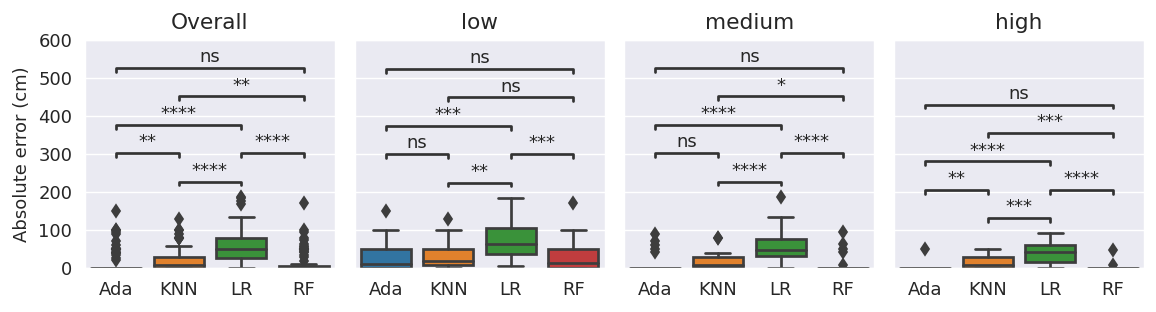

In [91]:
fig = compare_models('Infrared', df_grouped)
fig.savefig(os.path.join(results_dir,'ml_ir.pdf'))

p-value annotation legend:
ns: 5.00e-02 < p <= 1.00e+00
*: 1.00e-02 < p <= 5.00e-02
**: 1.00e-03 < p <= 1.00e-02
***: 1.00e-04 < p <= 1.00e-03
****: p <= 1.00e-04

KNN v.s. LR: t-test paired samples with Bonferroni correction, P_val=1.000e+00 stat=-1.173e+00
Ada v.s. KNN: t-test paired samples with Bonferroni correction, P_val=1.991e-03 stat=-3.734e+00
LR v.s. RF: t-test paired samples with Bonferroni correction, P_val=3.482e-10 stat=7.448e+00
Ada v.s. LR: t-test paired samples with Bonferroni correction, P_val=3.990e-08 stat=-6.414e+00
KNN v.s. RF: t-test paired samples with Bonferroni correction, P_val=1.434e-04 stat=4.459e+00
Ada v.s. RF: t-test paired samples with Bonferroni correction, P_val=1.000e+00 stat=8.880e-02


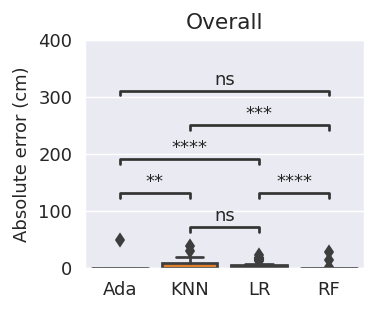

In [92]:
fig = compare_models('Ultrasound', df_grouped)
fig.savefig(os.path.join(results_dir,'ml_us.pdf'))

### Importances


In [93]:
df_imps_ir = pd.read_csv(os.path.join(results_dir,'importances_rf_ir.csv'),
                         index_col=0)
df_imps_ir['Model'] = 'Random Forest'

df_aux = pd.read_csv(os.path.join(results_dir,'importances_ada_ir.csv'),
                     index_col=0)
df_aux['Model'] = 'AdaBoost'
df_imps_ir = pd.concat([df_imps_ir,df_aux])

In [94]:
df_imps_us = pd.read_csv(os.path.join(results_dir,'importances_rf_us.csv'),
                         index_col=0)
df_imps_us['Model'] = 'RF-IR'

df_aux = pd.read_csv(os.path.join(results_dir,'importances_ada_us.csv'),
                     index_col=0)
df_aux['Model'] = 'Ada-IR'
df_imps_us = pd.concat([df_imps_us,df_aux])

In [95]:
df_imps_melt_ir = pd.melt(df_imps_ir, id_vars=['Model'],
                          var_name='Feature',
                          value_name='Importance')
df_imps_melt_us = pd.melt(df_imps_us, id_vars=['Model'],
                          var_name='Feature',
                          value_name='Importance')

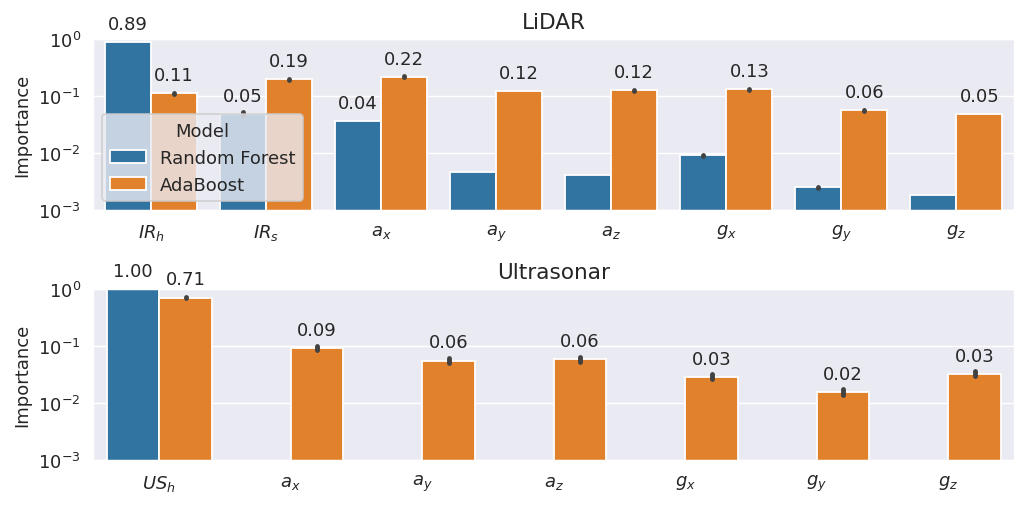

In [96]:
fig, ax = plt.subplots(nrows=2, figsize=(8,4), dpi=130)
for i, df_imps_melt in enumerate([df_imps_melt_ir, df_imps_melt_us]):
  sns.barplot(ax=ax[i],
              data=df_imps_melt,
              x='Feature',
              y='Importance',
              hue='Model')
  ax[i].set_yscale('log')
  ax[i].set_ylim(0.001,1)
  for p in ax[i].patches:
      if p.get_height() >= 0.01:
          ax[i].annotate(format(p.get_height(), '.2f'),
                        (p.get_x() + p.get_width() / 2., p.get_height()),
                        ha = 'center',
                        va = 'center',
                        xytext = (0, 10),
                        textcoords = 'offset points')
ax[0].set_title('LiDAR')
ax[1].set_title('Ultrasonar')
ax[0].set_xticklabels(['$IR_h$',
                       '$IR_s$',
                       '$a_x$',
                       '$a_y$',
                       '$a_z$',
                       '$g_x$',
                       '$g_y$',
                       '$g_z$'])
ax[1].set_xticklabels(['$US_h$',
                       '$a_x$',
                       '$a_y$',
                       '$a_z$',
                       '$g_x$',
                       '$g_y$',
                       '$g_z$'])
ax[0].set_xlabel('')
ax[1].set_xlabel('')
ax[1].legend().set_visible(False)
fig.tight_layout()
fig.savefig(os.path.join(results_dir,'importances.pdf'))

## ML vs raw data

### Generating mixed dataframe

In [97]:
df_grouped_raw = grouped_df_raw(df)
df_grouped_ml  = grouped_df_ml(df_res_all)

In [98]:
df_grouped_raw.rename(columns={'water_level': 'level',
                               'Turbidity': 'turbidity',
                               'modality': 'Sensor',
                               'abs_error': 'Error'},
                      inplace=True)
df_grouped_raw['Model'] = 'Raw'
df_grouped_raw['Sensor'] = df_grouped_raw['Sensor'].str.replace('ir_value',
                                                                'Infrared',
                                                                regex=False)
df_grouped_raw['Sensor'] = df_grouped_raw['Sensor'].str.replace('us_value',
                                                                'Ultrasound',
                                                                regex=False)
df_grouped_raw.rename({'sensor value': 'y_pred'},
                      axis=1,
                      inplace=True)
print(df_grouped_raw.columns)
df_grouped_raw.head()

Index(['level', 'angle', 'turbidity', 'Sensor', 'y_pred', 'Error', 'Model'], dtype='object')


,level,angle,turbidity,Sensor,y_pred,Error,Model
0,50.0,0.0,high,Infrared,51.0,1.0,Raw
1,50.0,0.0,low,Infrared,51.0,1.0,Raw
2,50.0,0.0,medium,Infrared,52.0,2.0,Raw
3,50.0,2.5,high,Infrared,50.0,0.0,Raw
4,50.0,2.5,low,Infrared,47.0,3.0,Raw


In [99]:
df_grouped_ml.drop(columns=['y_true'],
                   axis=1,
                   inplace=True)
df_grouped_ml.head()

,level,angle,turbidity,Model,Sensor,y_pred,Error
0,50.0,0.0,high,Ada,Infrared,50.00000,0.00000
1,50.0,0.0,high,Ada,Ultrasound,50.00000,0.00000
2,50.0,0.0,high,KNN,Infrared,80.00000,30.00000
3,50.0,0.0,high,KNN,Ultrasound,50.00000,0.00000
4,50.0,0.0,high,LR,Infrared,141.64563,91.64563


In [100]:
df_grouped_all = pd.concat([df_grouped_raw,
                            df_grouped_ml],
                           ignore_index=True)
df_grouped_all

,level,angle,turbidity,Sensor,y_pred,Error,Model
0,50.0,0.0,high,Infrared,51.000000,1.000000,Raw
1,50.0,0.0,low,Infrared,51.000000,1.000000,Raw
2,50.0,0.0,medium,Infrared,52.000000,2.000000,Raw
3,50.0,2.5,high,Infrared,50.000000,0.000000,Raw
4,50.0,2.5,low,Infrared,47.000000,3.000000,Raw
...,...,...,...,...,...,...,...
895,300.0,10.0,medium,Ultrasound,300.000000,0.000000,KNN
896,300.0,10.0,medium,Infrared,112.023909,187.976091,LR
897,300.0,10.0,medium,Ultrasound,300.301468,0.301468,LR
898,300.0,10.0,medium,Infrared,250.000000,50.000000,RF


### Prepare dataframe for analysis

In [101]:
df_conds = df_grouped_all.copy(deep=True)
df_conds['sensor_model'] = df_conds[['Sensor','Model']].agg('-'.join, axis=1)
conditions = ['Infrared-Raw',
              'Infrared-RF',
              'Ultrasound-Raw',
              'Ultrasound-RF']
df_conds = df_conds[df_conds['sensor_model'].isin(conditions)]
df_conds['sensor_model'] = df_conds['sensor_model'].str.replace('Infrared-Raw',
                                                                'IR',
                                                                regex=False)
df_conds['sensor_model'] = df_conds['sensor_model'].str.replace('Infrared-RF',
                                                                'IR-RF',
                                                                regex=False)
df_conds['sensor_model'] = df_conds['sensor_model'].str.replace('Ultrasound-Raw',
                                                                'US',
                                                                regex=False)
df_conds['sensor_model'] = df_conds['sensor_model'].str.replace('Ultrasound-RF',
                                                                'US-RF',
                                                                regex=False)
df_conds

<ipython-input-101-2aa2a8f99c4f>:8: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df_conds['sensor_model'] = df_conds['sensor_model'].str.replace('Infrared-Raw',
<ipython-input-101-2aa2a8f99c4f>:11: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df_conds['sensor_model'] = df_conds['sensor_model'].str.replace('Infrared-RF',
<ipython-input-101-2aa2a8f99c4f>:14: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

Se

,level,angle,turbidity,Sensor,y_pred,Error,Model,sensor_model
0,50.0,0.0,high,Infrared,51.0,1.0,Raw,IR
1,50.0,0.0,low,Infrared,51.0,1.0,Raw,IR
2,50.0,0.0,medium,Infrared,52.0,2.0,Raw,IR
3,50.0,2.5,high,Infrared,50.0,0.0,Raw,IR
4,50.0,2.5,low,Infrared,47.0,3.0,Raw,IR
...,...,...,...,...,...,...,...,...
883,300.0,10.0,high,Ultrasound,300.0,0.0,RF,US-RF
890,300.0,10.0,low,Infrared,243.0,57.0,RF,IR-RF
891,300.0,10.0,low,Ultrasound,300.0,0.0,RF,US-RF
898,300.0,10.0,medium,Infrared,250.0,50.0,RF,IR-RF


### Compare models by turbidity

In [102]:
def compute_anova_sensor_model(df_a):
  fvalue, pvalue = f_oneway(df_a[df_a['sensor_model']=='IR']['Error'],
                            df_a[df_a['sensor_model']=='US']['Error'],
                            df_a[df_a['sensor_model']=='IR-RF']['Error'],
                            df_a[df_a['sensor_model']=='US-RF']['Error'])
  print('Overall', fvalue, pvalue)
  df_ = df_a[df_a['turbidity']=='low']
  fvalue, pvalue = f_oneway(df_[df_['sensor_model']=='IR']['Error'],
                            df_[df_['sensor_model']=='US']['Error'],
                            df_[df_['sensor_model']=='IR-RF']['Error'],
                            df_[df_['sensor_model']=='US-RF']['Error'])
  print('Low', fvalue, pvalue)
  df_ = df_a[df_a['turbidity']=='medium']
  fvalue, pvalue = f_oneway(df_[df_['sensor_model']=='IR']['Error'],
                            df_[df_['sensor_model']=='US']['Error'],
                            df_[df_['sensor_model']=='IR-RF']['Error'],
                            df_[df_['sensor_model']=='US-RF']['Error'])
  print('Medium', fvalue, pvalue)
  df_ = df_a[df_a['turbidity']=='high']
  fvalue, pvalue = f_oneway(df_[df_['sensor_model']=='IR']['Error'],
                            df_[df_['sensor_model']=='US']['Error'],
                            df_[df_['sensor_model']=='IR-RF']['Error'],
                            df_[df_['sensor_model']=='US-RF']['Error'])
  print('High', fvalue, pvalue)

In [103]:
compute_anova_sensor_model(df_conds)

Overall 30.77011982254468 1.0401530172422071e-17
Low 18.312117148011602 8.554898893048812e-10
Medium 10.56732956262075 3.387365105178911e-06
High 28.020188995802116 1.0589282989565964e-13


p-value annotation legend:
ns: 5.00e-02 < p <= 1.00e+00
*: 1.00e-02 < p <= 5.00e-02
**: 1.00e-03 < p <= 1.00e-02
***: 1.00e-04 < p <= 1.00e-03
****: p <= 1.00e-04

US v.s. IR-RF: t-test independent samples with Bonferroni correction, P_val=6.041e-03 stat=-3.344e+00
IR v.s. US: t-test independent samples with Bonferroni correction, P_val=5.307e-08 stat=6.038e+00
IR-RF v.s. US-RF: t-test independent samples with Bonferroni correction, P_val=1.759e-04 stat=4.290e+00
IR v.s. IR-RF: t-test independent samples with Bonferroni correction, P_val=5.658e-05 stat=4.561e+00
US v.s. US-RF: t-test independent samples with Bonferroni correction, P_val=2.891e-03 stat=3.556e+00
IR v.s. US-RF: t-test independent samples with Bonferroni correction, P_val=9.444e-09 stat=6.369e+00
p-value annotation legend:
ns: 5.00e-02 < p <= 1.00e+00
*: 1.00e-02 < p <= 5.00e-02
**: 1.00e-03 < p <= 1.00e-02
***: 1.00e-04 < p <= 1.00e-03
****: p <= 1.00e-04

US v.s. IR-RF: t-test independent samples with Bonferroni correct

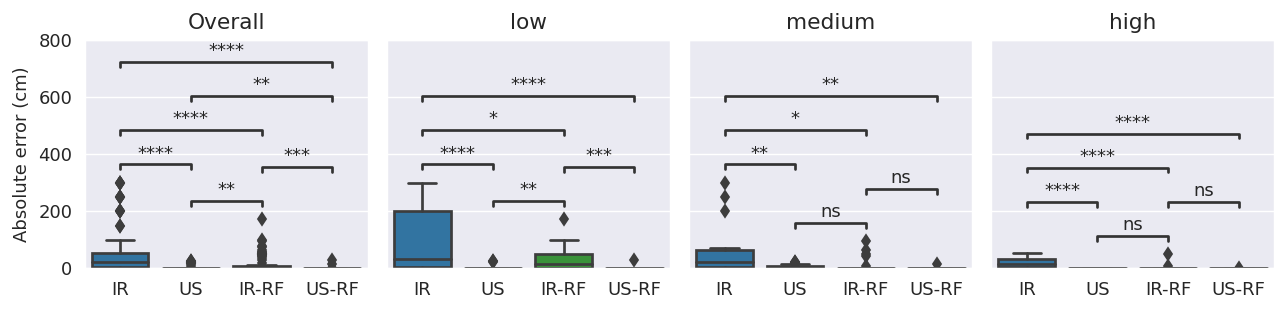

In [104]:
fig, ax = plt.subplots(ncols=4, sharey=True, figsize=(10,2.5), dpi=130)
#fig, ax = plt.subplots(nrows=3, sharey=True, figsize=(3,6), dpi=130)
for i, turbidity in enumerate([None, 'low','medium','high']):
  ax[i].set_ylim(0,800)
  if turbidity is None:
    df_ = df_conds
    ax[i].set_title('Overall')
  else:
    df_ = df_conds[df_conds['turbidity']==turbidity]
    ax[i].set_title(turbidity)
  sns.boxplot(ax=ax[i], data=df_, x='sensor_model', y='Error')
  box_pairs=[('IR', 'IR-RF'),
            ('US', 'IR-RF'),
            ('US','IR'),
            ('IR-RF','US-RF'),
            ('IR','US-RF')]
  if turbidity is None:
    box_pairs.append(('US','US-RF'))
  test_results = add_stat_annotation(ax[i],
                                    data=df_,
                                    x='sensor_model',
                                    y='Error',
                                    box_pairs=box_pairs,
                                    test='t-test_ind',
                                    text_format='star',
                                    loc='inside',
                                    verbose=2)
ax[0].set_ylabel('Absolute error (cm)')
ax[1].set_ylabel('')
ax[2].set_ylabel('')
ax[3].set_ylabel('')
#ax[1].set_ylabel('Absolute error (cm)')
#ax[2].set_ylabel('Absolute error (cm)')
ax[0].set_xlabel('')
ax[1].set_xlabel('')
ax[2].set_xlabel('')
ax[3].set_xlabel('')
fig.tight_layout()
fig.savefig(os.path.join(results_dir,'models_comp.pdf'))

In [105]:
columns = ['Model','Turbidity','MAE','RMSE','R2']
df_metrics = pd.DataFrame(columns=columns)
for i, sensor_model in enumerate(df_conds['sensor_model'].unique()):
  df_ = df_conds[df_conds['sensor_model']==sensor_model]
  df_ = df_.rename(columns={'level': 'y_true'})
  df_metrics_model = eval_model(df_, sensor_model)
  df_metrics = pd.concat([df_metrics,df_metrics_model],
                         ignore_index=True)
df_metrics.sort_values(by='Turbidity').round(2)

,Model,Turbidity,MAE,RMSE,R2
0,IR,Overall,56.31,99.96,-0.37
4,US,Overall,3.28,7.31,0.99
8,IR-RF,Overall,13.94,32.47,0.86
12,US-RF,Overall,0.51,3.43,1.00
3,IR,high,19.28,25.31,0.91
7,US,high,1.07,1.20,1.00
11,IR-RF,high,1.90,9.06,0.99
15,US-RF,high,0.07,0.37,1.00
1,IR,low,99.27,146.93,-1.96
5,US,low,3.09,7.65,0.99


### Compare models by angle

In [106]:
def compute_anova_sensor_model_angle(df_a):
  for angle in [0,2.5,5,7.5,10]:
    df_ = df_a[df_a['angle']==angle]
    fvalue, pvalue = f_oneway(df_[df_['sensor_model']=='IR']['Error'],
                              df_[df_['sensor_model']=='US']['Error'],
                              df_[df_['sensor_model']=='IR-RF']['Error'],
                              df_[df_['sensor_model']=='US-RF']['Error'])
    print(f'Angle = {angle}', fvalue, pvalue)

In [107]:
compute_anova_sensor_model_angle(df_conds)

Angle = 0 0.6177658997359813 0.6058759037871226
Angle = 2.5 13.604428046731647 4.765540453824196e-07
Angle = 5 8.70460832334591 5.767440682263566e-05
Angle = 7.5 12.585931857589838 1.2267172020727328e-06
Angle = 10 17.751732386897615 1.2926436375901522e-08


p-value annotation legend:
ns: 5.00e-02 < p <= 1.00e+00
*: 1.00e-02 < p <= 5.00e-02
**: 1.00e-03 < p <= 1.00e-02
***: 1.00e-04 < p <= 1.00e-03
****: p <= 1.00e-04

US v.s. IR-RF: t-test independent samples with Bonferroni correction, P_val=1.312e-01 stat=2.403e+00
IR v.s. US: t-test independent samples with Bonferroni correction, P_val=1.894e-01 stat=2.242e+00
IR-RF v.s. US-RF: t-test independent samples with Bonferroni correction, P_val=1.000e+00 stat=1.000e+00
IR v.s. IR-RF: t-test independent samples with Bonferroni correction, P_val=6.303e-05 stat=5.165e+00
US v.s. US-RF: t-test independent samples with Bonferroni correction, P_val=9.210e-02 stat=2.553e+00
IR v.s. US-RF: t-test independent samples with Bonferroni correction, P_val=4.002e-05 stat=5.316e+00
p-value annotation legend:
ns: 5.00e-02 < p <= 1.00e+00
*: 1.00e-02 < p <= 5.00e-02
**: 1.00e-03 < p <= 1.00e-02
***: 1.00e-04 < p <= 1.00e-03
****: p <= 1.00e-04

US v.s. IR-RF: t-test independent samples with Bonferroni correcti

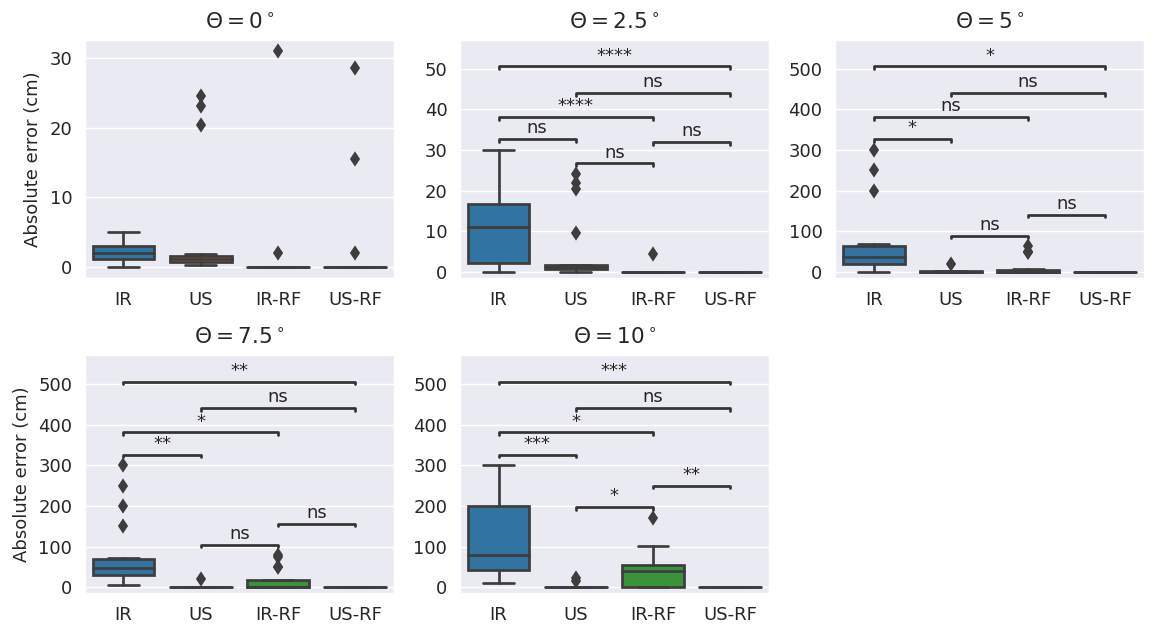

In [108]:
fig, ax = plt.subplots(ncols=3, nrows=2, figsize=(9,5), dpi=130)
for i, angle in enumerate([0,2.5,5,7.5,10]):
  df_ = df_conds[df_conds['angle']==angle]
  sns.boxplot(ax=ax[i//3,i%3], data=df_, x='sensor_model', y='Error')
  box_pairs=[('IR', 'IR-RF'),
            ('US', 'IR-RF'),
            ('US', 'IR'),
            ('US', 'US-RF'),
            ('IR-RF','US-RF'),
            ('US-RF', 'IR')]
  if angle != 0:
    test_results = add_stat_annotation(ax[i//3,i%3],
                                      data=df_,
                                      x='sensor_model',
                                      y='Error',
                                      box_pairs=box_pairs,
                                      test='t-test_ind',
                                      text_format='star',
                                      loc='inside',
                                      verbose=2)
  ax[i//3,i%3].set_title(f'$\Theta={angle}^\circ$')
ax[1,2].set_visible(False)
ax[0,0].set_ylabel('Absolute error (cm)')
ax[0,1].set_ylabel('')
ax[0,2].set_ylabel('')
ax[1,0].set_ylabel('Absolute error (cm)')
ax[1,1].set_ylabel('')
ax[0,0].set_xlabel('')
ax[0,1].set_xlabel('')
ax[0,2].set_xlabel('')
ax[1,0].set_xlabel('')
ax[1,1].set_xlabel('')
fig.tight_layout()
fig.savefig(os.path.join(results_dir,'models_comp_angle.pdf'))

In [109]:
columns = ['Model','Angle','MAE','RMSE','R2']
df_metrics = pd.DataFrame(columns=columns)
for i, sensor_model in enumerate(df_conds['sensor_model'].unique()):
  df_ = df_conds[df_conds['sensor_model']==sensor_model]
  df_ = df_.rename(columns={'level': 'y_true'})
  df_metrics_model = eval_model_angle(df_, sensor_model)
  df_metrics = pd.concat([df_metrics,df_metrics_model],
                         ignore_index=True)
df_metrics.sort_values(by='Angle').round(2)

,Model,Angle,MAE,RMSE,R2
0,IR,0,2.33,2.65,1.00
5,US,0,4.65,9.34,0.99
10,IR-RF,0,1.83,7.32,0.99
15,US-RF,0,2.56,7.66,0.99
1,IR,2.5,11.39,14.41,0.97
6,US,2.5,4.92,9.35,0.99
11,IR-RF,2.5,0.25,1.06,1.00
16,US-RF,2.5,0.00,0.00,1.00
2,IR,5,67.22,108.89,-0.63
17,US-RF,5,0.00,0.00,1.00
